# Dimers in confinement in a precessing magnetic field

In [316]:
import os
import sys
import copy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as anm

from IPython.display import display, HTML
%matplotlib inline

At this moment the input script for lammps is empty. However this successfully runs lammps and does nothing. 

In [317]:
def LAMMPSRun(filename,target_dir):
    """This function runs an input script named filename in lammps. The input should be located in target_dir"""
    if sys.platform=='darwin':
        LAMMPSExec = "./lmp_mac"
    else:
        LAMMPSExec = "lmp_mingw64.exe"

    os.system(LAMMPSExec + " -in "+filename+".lmpin")

    lammpstrj = os.path.join(target_dir,filename+".lammpstrj")
    lammpsinput = os.path.join(target_dir,filename+".lmpin")
    
    return lammpstrj, lammpsinput

In [318]:
LAMMPSRun('TestDimerSim',"")

('TestDimerSim.lammpstrj', 'TestDimerSim.lmpin')

## Populating the input script

### Preamble
We start by writing the preamble:

    units micro
    atom_style hybrid sphere paramagnet
    boundary s s f
    neighbor 4.0 nsq
    pair_style lj/cut/dipole/cut 200

### System Definition

    region space block -100 100 -100 100 -10 10 # this is in microns
    create_box 1 space
    
    create_atoms 1 single 10 0 0
    create_atoms 1 single -10 0 0
    
    pair_coeff	* * 1.0 1.0

### Particle Properties
    
    mass * 1
    set group all paramagnet 1
    
    
### Fixes ###
    variable Bmax atom 0.001080
    variable Tmax atom 1.000000e+00
    variable field atom v_Bmax-(abs((v_Bmax/v_Tmax*(time-v_Tmax)))-(v_Bmax/v_Tmax*(time-v_Tmax)))/2

    fix 	1 Atoms bd 300.000000 0.030000 1
    fix 	4 Atoms setdipole 0 0 v_field

### Run ###
    timestep 	1000
    dump 	3 all custom 100 TestDimerSim.lammpstrj id type x y z mu
    thermo_style 	custom step atoms
    thermo 	100
    run 	60000

In [322]:
LAMMPSRun('TestDimerSim',"")

('TestDimerSim.lammpstrj', 'TestDimerSim.lmpin')

In [323]:
lammps_traj_lz = LazyOpenLAMMPSTrj('TestDimerSim.lammpstrj')
Trj = lammps_traj_lz.readtrj()
Trj.head()

mu type        x         y         z
frame id                                            
0     1   0.000000    1  10.0000  0.000000  0.000000
      2   0.000000    1 -10.0000  0.000000  0.000000
100   1   0.000565    1  10.6036  0.258609  0.350378
      2   0.000565    1 -10.3378  0.108014 -0.182523
200   1   0.000565    1  10.5679  0.244987  0.233789

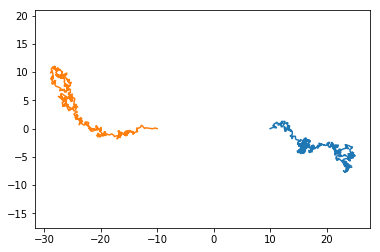

In [324]:
idx = pd.IndexSlice
for i in Trj.index.get_level_values('id').unique():
    plt.plot(Trj.loc[idx[:,i],'x'],Trj.loc[idx[:,i],'y'])
plt.axis('equal');

Error: Lost atoms: original 2 current 1

From Lammps [Error Section](http://lammps.sandia.gov/doc/Section_errors.html)
> Lost atoms: original %ld current %ld: 
Lost atoms are checked for each time thermo output is done. See the thermo_modify lost command for options. Lost atoms usually indicate bad dynamics, e.g. atoms have been blown far out of the simulation box, or moved further than one processor’s sub-domain away before reneighboring.

### Fixed lost atoms

If I change the region to 

    region space block -100 100 -100 100 -100 100 # this is in microns
    create_box 1 space
    
Then I get rid of the lost atoms error. Of course this is the case, because the region was fixed in the z direction.

If we plotted the prevous result:

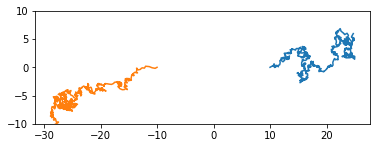

In [343]:
for i in Trj.index.get_level_values('id').unique():
    plt.plot(Trj.loc[idx[:,i],'x'],Trj.loc[idx[:,i],'z'])
    
plt.axis('square');
plt.ylim([-10,10]);

Which shows how a particle is lost because it leaves the region. 

# Support Functions

In [274]:
def AnimateTrayectory(T):
    NumberOfFrames = T.index.max()

    fig, ax = plt.subplots(1,1,figsize=(8,6))
    Points = ax.plot(0,0,'o')
    Center = ax.plot(0,0,'o',color='red')
    plt.xlim([-300,100])
    plt.ylim([-150,200])
    plt.close()

    def init():
        Points[0].set_data([],[])
        Center[0].set_data([], [])
        return (Points,Center)

    def animate(i):
        fr_ind=(T.index==i)
        Points[0].set_data(T[fr_ind].x0,T[fr_ind].y0)
        Center[0].set_data(0,0)
        return (Points,Center)

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                       frames=T.index.unique(), interval=200, blit=False)
    return anim

## LAMMPS Read Function

This was taken from the IceNumerics function

In [273]:
class LazyOpenLAMMPSTrj():
    def __init__(self,Filename):
        self.T = dict([])
        self.Name = Filename
        item = dict([])
        with open(Filename) as d:
            line = "d"
            while line:
                line = d.readline()
                
                if 'ITEM: TIMESTEP' in line:
                    line = d.readline()
                    t = int(line)
                    
                if 'ITEM: NUMBER OF ATOMS' in line:
                    line = d.readline()
                    item["atoms"] = int(line)
                    
                if 'ITEM: ATOMS' in line:
                    item["location"] = d.tell()
                    self.T[t] = cp.deepcopy(item)
                
    def readframe(self,time):
        Atoms = np.zeros(
            int(self.T[time]["atoms"]),
            dtype={
                'names':['id','type','x','y','z','mu'],
                'formats':['i8','i8','float32','float32','float32','float32']})
        j=0
        with open(self.Name) as d:
            d.seek(self.T[time]["location"])
            for i in range(0,int(self.T[time]["atoms"])):
                line = d.readline()
                linearray = np.array([float(i) for i in line.split(' ') if i!='\n'])
                Atoms['id'][j] = int(linearray[0])
                Atoms['type'][j] = int(linearray[1])
                Atoms['x'][j] = linearray[2]
                Atoms['y'][j] = linearray[3]
                Atoms['z'][j] = linearray[4]
                Atoms['mu'][j] = linearray[5]
                j=j+1;
        return Atoms
    def readtrj(self):
        
        columns=['frame']+list(self.readframe(100).dtype.names)
        frames = np.sort(np.array(list(self.T.keys())))

        accum = pd.DataFrame(index=[],columns=columns)

        for i in frames:
            frame_data = self.readframe(i)
            entry = pd.DataFrame(data=frame_data)
            entry['frame']=i
            accum = accum.append(entry)
#            for part in frame_data: 
#                data = [np.array([i]+list(part))]
#                entry = pd.DataFrame(data=data,columns=columns)
#                accum = accum.append(entry)
        
        accum = accum.set_index(['frame','id'])
        return accum